# Question 1
1.   Full Name: Farhad Fallah 
2.   Student Number: 97102214

In [1]:
import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [2]:
import tensorflow as tf
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense ,Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error,accuracy_score , recall_score , precision_score,confusion_matrix 
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback


### dropblock definition

In [5]:
# Author: An Jiaoyang # https://github.com/DHZS/tf-dropblock # =============================
import tensorflow as tf
from tensorflow.python.keras import backend as K


class DropBlock(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, **kwargs):
        super(DropBlock, self).__init__(**kwargs)
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'keep_prob': self.keep_prob,
            'block_size': self.block_size,
            
        })
        return config
    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        _, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask         
        bottom = right = (self.block_size - 1) // 2
        top = left = (self.block_size - 1) - bottom
        self.padding = [[0, 0], [top, bottom], [left, right], [0, 0]]
        self.set_keep_prob()
        super(DropBlock, self).build(input_shape)

    def call(self, inputs, training=None, scale=True, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale,
                             true_fn=lambda: output * float(tf.size(mask)) / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        w, h = float(self.w), float(self.h)
        self.gamma = (1. - self.keep_prob) * (w * h) / (self.block_size ** 2) / \
                     ((w - self.block_size + 1) * (h - self.block_size + 1))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                       self.h - self.block_size + 1,
                                       self.w - self.block_size + 1,
                                       self.channel])
        mask = DropBlock._bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool(mask, [1, self.block_size, self.block_size, 1], [1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask

    @staticmethod
    def _bernoulli(shape, mean):
        return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))

## Part1
### reading data 
با توجه به مشکلات رم در بخش های بعدی، در همین ابتدا عکس هارا 0.75 برابر ریسایز میکنیم.

In [6]:
import glob
import cv2
X = []
Y = []
# absolute path to search all text files inside a specific folder
labels = {'Boot':0 , 'Sandal':1 , 'Shoe':2}
image_path = '/content/drive/MyDrive/deep/Shoe vs Sandal vs Boot Dataset'
for cls in os.listdir(image_path):
    #print(labels[cls])
    dir = os.path.join(image_path , cls)
    #print(dir)
    for file in os.listdir(dir):
        img_dir = os.path.join(dir, file)
        #print(img_dir)
        img = cv2.imread(img_dir)
        img = cv2.resize(img , (102,76))
        X.append(img)
        Y.append(labels[cls])

## displaying classes

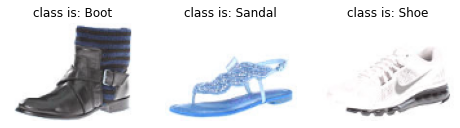

In [7]:
X_Y = list(zip(X,Y)) # Zip images and associated label
random.shuffle(X_Y) # Shuffle
i = 0
fig, axs = plt.subplots(1,3, figsize=[8,8])
labels_dic = {0:'Boot' , 1:'Sandal' , 2:'Shoe'}

for x , y in X_Y:
    
    if y ==i:
        plt.subplot(1,3,i+1)
        plt.imshow(x)
        plt.axis('off')
        plt.title(f'class is: {labels_dic[i]}')
        i = i + 1
    if i==3:
          break

In [8]:
X, Y = zip(*X_Y)
X = np.array(X) / 255
Y = np.array(Y).reshape(15000,1)
print(X.shape , Y.shape)

(15000, 76, 102, 3) (15000, 1)


### train, validation, test split 

In [9]:
test_size = 0.3
val_size = 0.2
train_size = 0.5
ohe = OneHotEncoder(categories='auto', sparse=False)
Y_ohe = ohe.fit_transform(Y)
X_train = X[0:int((0.5)*15000)]
X_val = X[int((0.5)*15000):int((0.7)*15000)]
X_test = X[int((0.7)*15000):]

Y_train = Y_ohe[0:int((0.5)*15000)]
Y_val = Y_ohe[int((0.5)*15000):int((0.7)*15000)]
Y_test = Y_ohe[int((0.7)*15000):]
print(X_train.shape , Y_train.shape )
print(X_val.shape , Y_val.shape )
print(X_test.shape , Y_test.shape )
del X
del Y
del X_Y
del Y_ohe

(7500, 76, 102, 3) (7500, 3)
(3000, 76, 102, 3) (3000, 3)
(4500, 76, 102, 3) (4500, 3)


## Part2
### model1:MLP

در این بخش به طراحی شبکه پرسپترون میپردازیم تعداد پارامتر ها و معماری شبکه در ادامه نمایش داده شده است.

In [10]:
model = tf.keras.Sequential(name = 'FirstModel')
model.add(Flatten(name = 'flatten'))
model.add(Dense(16, activation='relu',name = 'D1'))
model.add(BatchNormalization())

#model.add(Dropout(.5, name='Dropout1'))
model.add(Dense(16, activation='relu',name = 'D2'))
model.add(BatchNormalization())

model.add(Dense(16, activation='relu',name = 'D3'))
model.add(Dropout(.2, name='Dropout3'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu',name = 'D4'))

model.add(Dense(3, activation='softmax',name = 'D5'))



In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "FirstModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (32, 23256)               0         
                                                                 
 D1 (Dense)                  (32, 16)                  372112    
                                                                 
 batch_normalization (BatchN  (32, 16)                 64        
 ormalization)                                                   
                                                                 
 D2 (Dense)                  (32, 16)                  272       
                                                                 
 batch_normalization_1 (Batc  (32, 16)                 64        
 hNormalization)                                                 
                                                                 
 D3 (Dense)                  (32, 16)                  2

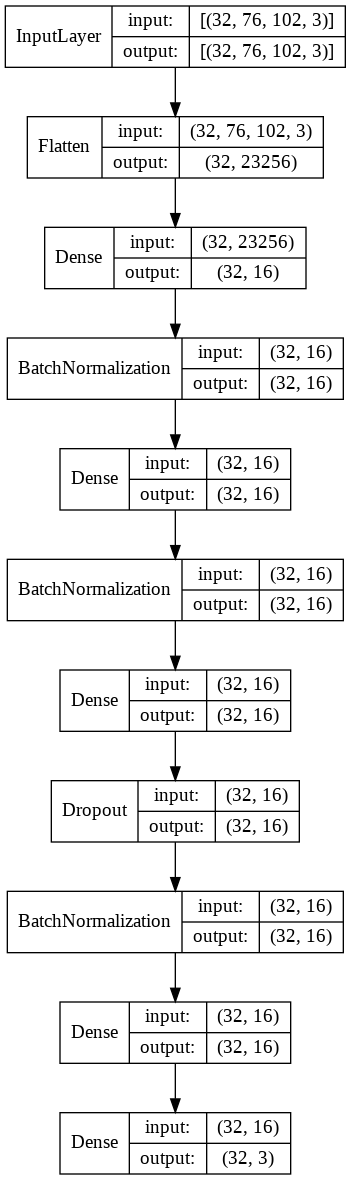

In [12]:
model.build(input_shape=(32, 76, 102, 3))
model.summary()
plot_model(model, show_shapes=True, show_layer_names=False)

In [13]:

es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('mlp.h5', monitor='val_loss', mode='min', save_best_only=True)

In [14]:
epch = 120

In [15]:
history = model.fit(X_train, Y_train, callbacks=[es, rlrop, mch], validation_data=(X_val, Y_val), epochs=epch, batch_size=32)

Epoch 1/120
235/235 [==============================] - 11s 29ms/step - loss: 0.5953 - accuracy: 0.7660 - val_loss: 3.5218 - val_accuracy: 0.3380 - lr: 0.0010
Epoch 2/120
235/235 [==============================] - 3s 12ms/step - loss: 0.3986 - accuracy: 0.8500 - val_loss: 1.1574 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 3/120
235/235 [==============================] - 3s 14ms/step - loss: 0.3199 - accuracy: 0.8836 - val_loss: 0.6104 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 4/120
235/235 [==============================] - 3s 12ms/step - loss: 0.2890 - accuracy: 0.8948 - val_loss: 1.4065 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 5/120
235/235 [==============================] - 2s 9ms/step - loss: 0.2483 - accuracy: 0.9120 - val_loss: 0.2670 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 6/120
235/235 [==============================] - 2s 10ms/step - loss: 0.2422 - accuracy: 0.9183 - val_loss: 0.5361 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 7/120
235/235 [==============================] - 2s 

## Part 3

Text(0.5, 1.0, 'Accuracy')

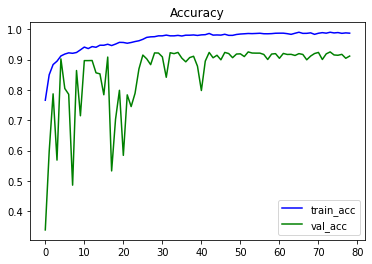

In [16]:
plt.plot(history.history['accuracy'], color='blue',label = 'train_acc')
plt.plot(history.history['val_accuracy'], color='green' , label = 'val_acc')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

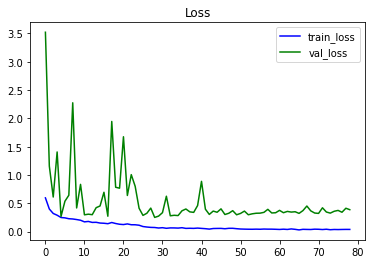

In [17]:
plt.plot(history.history['loss'], color='blue',label = 'train_loss')
plt.plot(history.history['val_loss'], color='green' , label='val_loss')
plt.legend()
plt.title('Loss')

In [18]:
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

141/141 [==============================] - 2s 12ms/step - loss: 0.3596 - accuracy: 0.9160
Test loss: 0.35961100459098816
Test accuracy: 0.9160000085830688


In [19]:
Y_pred = model.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)

141/141 [==============================] - 1s 9ms/step


In [20]:
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

In [21]:
accuracy = accuracy_score(Y_pred_labels , Y_test_labels)
recall = recall_score(Y_pred_labels , Y_test_labels , average = 'macro')
precision = precision_score(Y_pred_labels , Y_test_labels , average = 'macro')
print(f'accuracy:{accuracy :0.3f}\t Recall:{recall:0.3f} \t precision{precision:0.3f} \t loss:{score[0]:0.3f}' )

accuracy:0.916	 Recall:0.918 	 precision0.916 	 loss:0.360


In [22]:
labels = labels=["Shoe", "Sandal", "Boot"]
confusion_matrix(Y_test_labels, Y_pred_labels, normalize='true') * 100

array([[93.94141145,  4.12782956,  1.93075899],
       [ 2.25763612, 93.42629482,  4.31606906],
       [ 1.74262735, 10.85790885, 87.39946381]])

In [23]:
del Y_pred , Y_pred_max , Y_pred_labels , model, history, rlrop, mch, es

## Part4
در این بخش به پیاده سازی مدلی با تعداد پارامتر های کمتر از شبکه پرسپترون و به کمک شبکه های کانولوشنی میپردازیم.
برای این منظور از ساختار زیر استفاده میکنم و از لایه های `drop out` استفاده شده در بخش قبل استفاده میکنیم.

In [24]:
model2 = Sequential()
model2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(76, 102, 3) , name = 'Conv2D-1' , padding = 'same'))
model2.add(MaxPool2D(pool_size=(2, 2) , name = 'MaxPool-1', padding = 'same'))
model2.add(Dropout(.1, name='Dropout1'))
model2.add(Conv2D(32, (3, 3), activation='relu', name = 'Conv2D-2', padding = 'same'))
model2.add(MaxPool2D(pool_size=(2, 2), name = 'MaxPool-2'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', name = 'Conv2D-3', padding = 'same'))
model2.add(Dropout(.1, name='Dropout2'))
model2.add(MaxPool2D(pool_size=(2, 2), name = 'MaxPool-3'))
model2.add(BatchNormalization())
model2.add(Flatten( name = 'Flatten'))
model2.add(Dense(32, activation='relu', name = 'Dense-1'))
model2.add(Dropout(.1, name='Dropout3'))
model2.add(BatchNormalization())
model2.add(Dense(16, activation='relu', name = 'Dense-2'))
model2.add(BatchNormalization())
model2.add(Dense(3, activation='softmax', name = 'Dense-3'))

In [25]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 76, 102, 16)       448       
                                                                 
 MaxPool-1 (MaxPooling2D)    (None, 38, 51, 16)        0         
                                                                 
 Dropout1 (Dropout)          (None, 38, 51, 16)        0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 38, 51, 32)        4640      
                                                                 
 MaxPool-2 (MaxPooling2D)    (None, 19, 25, 32)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 19, 25, 32)       128       
 hNormalization)                                                 
                                                        

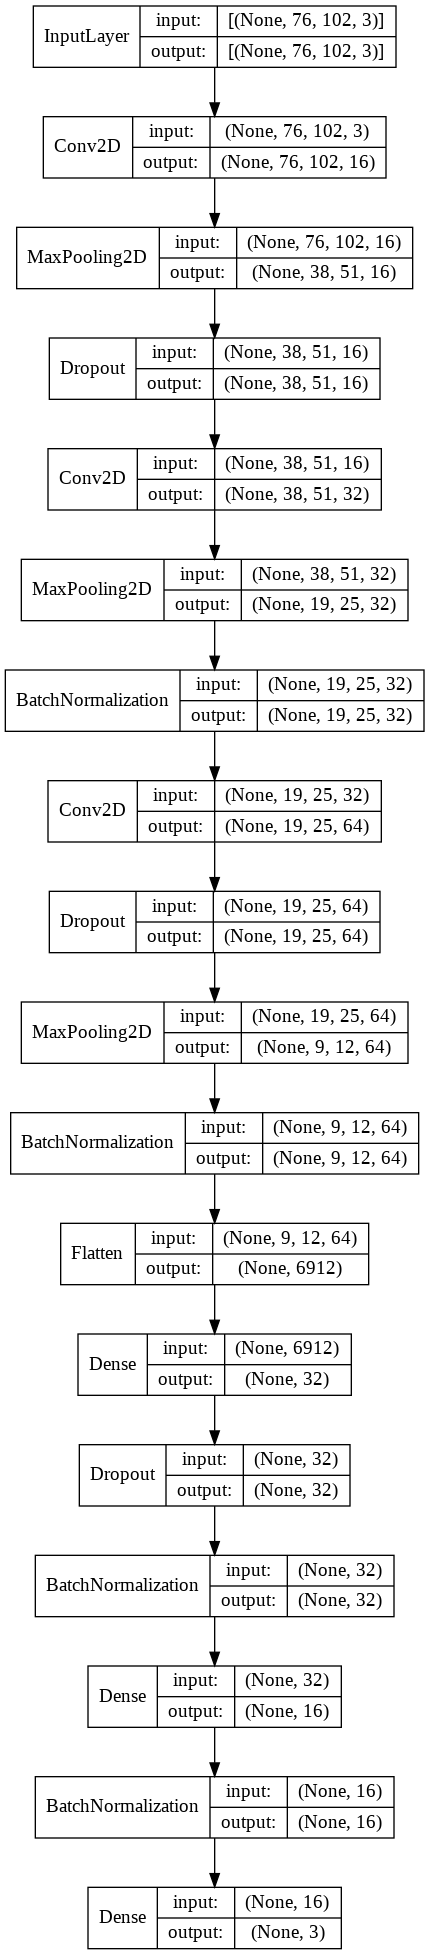

In [26]:
model2.build(input_shape=(32, 76, 102, 3))
model2.summary()
plot_model(model2, show_shapes=True, show_layer_names=False)

In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('cnn_dropout.h5', monitor='val_loss', mode='min', save_best_only=True)

In [28]:
history2 = model2.fit(X_train, Y_train, callbacks=[es, rlrop, mch], validation_data=(X_val, Y_val), epochs=epch, batch_size=32)

Epoch 1/120
235/235 [==============================] - 13s 31ms/step - loss: 0.3523 - accuracy: 0.8705 - val_loss: 1.0851 - val_accuracy: 0.6107 - lr: 0.0010
Epoch 2/120
235/235 [==============================] - 3s 12ms/step - loss: 0.1801 - accuracy: 0.9360 - val_loss: 0.3704 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 3/120
235/235 [==============================] - 4s 15ms/step - loss: 0.1289 - accuracy: 0.9568 - val_loss: 5.1344 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 4/120
235/235 [==============================] - 3s 13ms/step - loss: 0.1035 - accuracy: 0.9644 - val_loss: 0.1208 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 5/120
235/235 [==============================] - 4s 17ms/step - loss: 0.1418 - accuracy: 0.9501 - val_loss: 0.2696 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 6/120
235/235 [==============================] - 3s 12ms/step - loss: 0.1197 - accuracy: 0.9588 - val_loss: 0.1390 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 7/120
235/235 [==============================] - 3s

Text(0.5, 1.0, 'Accuracy')

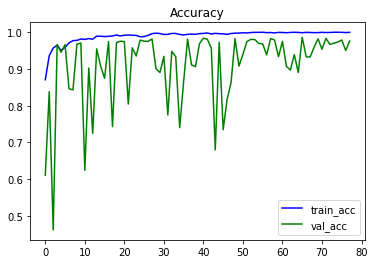

In [29]:
plt.plot(history2.history['accuracy'], color='blue',label = 'train_acc')
plt.plot(history2.history['val_accuracy'], color='green' , label = 'val_acc')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

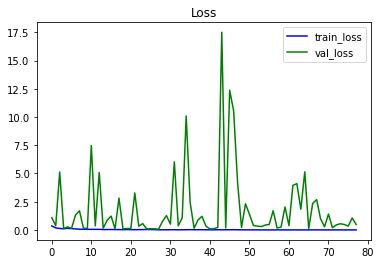

In [30]:
plt.plot(history2.history['loss'], color='blue',label = 'train_loss')
plt.plot(history2.history['val_loss'], color='green' , label='val_loss')
plt.legend()
plt.title('Loss')

In [31]:
score = model2.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

141/141 [==============================] - 2s 11ms/step - loss: 0.3326 - accuracy: 0.9724
Test loss: 0.33256813883781433
Test accuracy: 0.9724444150924683


In [32]:
Y_pred = model2.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

141/141 [==============================] - 2s 13ms/step


In [33]:
accuracy = accuracy_score(Y_pred_labels , Y_test_labels)
recall = recall_score(Y_pred_labels , Y_test_labels , average = 'macro')
precision = precision_score(Y_pred_labels , Y_test_labels , average = 'macro')
print(f'accuracy:{accuracy :0.3f}\t Recall:{recall:0.3f} \t precision{precision:0.3f} \t loss:{score[0]:0.3f}' )

accuracy:0.972	 Recall:0.973 	 precision0.972 	 loss:0.333


## Part5:
در این بخش میبینیم که شبکه ما با 0.65 پارامتر های شبکه `MLP` سابق دقت بسیار بهتری دارد. 

In [34]:
del Y_pred , Y_pred_max , Y_pred_labels , model2, history2, rlrop, mch, es

## Part6:

در شبکه های کانولوشنی عملکرد `block dropout` بهتر از `drop out` معمولی است زیرا، dropout به صورت رندوم نقاطی از تصویر را حذف میکند اما در block droput این عمل به صورت بلوک بلوک انجام میشود، و عملا بخشی از تصویر را نادیده میگیرد و به این صورت بخش های مهم تر تصویر را نیز میتوان تشخیص داد.با مشاهده نتایج و نمودار ها با بخش قبل میبینیم که در اکثر موارد دقت ما بهتر است و همگرایی نمودار خطا و دقت نیز بیشتر می باشد که دلایل ان ذکر شد.

In [35]:
model3 = Sequential()
model3.add(Conv2D(16, (3, 3), activation='relu', input_shape=(76, 102, 3) , name = 'Conv2D-1' , padding = 'same'))
model3.add(MaxPool2D(pool_size=(2, 2) , name = 'MaxPool-1', padding = 'same'))
model3.add(DropBlock(keep_prob=0.9, block_size=3))

#model3.add(Dropout(.1, name='Dropout1'))
model3.add(Conv2D(32, (3, 3), activation='relu', name = 'Conv2D-2', padding = 'same'))
model3.add(MaxPool2D(pool_size=(2, 2), name = 'MaxPool-2'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3, 3), activation='relu', name = 'Conv2D-3', padding = 'same'))
model3.add(DropBlock(keep_prob=0.9, block_size=3))
model3.add(MaxPool2D(pool_size=(2, 2), name = 'MaxPool-3'))
model3.add(BatchNormalization())
model3.add(Flatten( name = 'Flatten'))
model3.add(Dense(32, activation='relu', name = 'Dense-1'))
model3.add(Dropout(.1, name='Dropout3'))
model3.add(BatchNormalization())
model3.add(Dense(16, activation='relu', name = 'Dense-2'))
model3.add(BatchNormalization())
model3.add(Dense(3, activation='softmax', name = 'Dense-3'))

In [36]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 76, 102, 16)       448       
                                                                 
 MaxPool-1 (MaxPooling2D)    (None, 38, 51, 16)        0         
                                                                 
 drop_block (DropBlock)      (None, 38, 51, 16)        0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 38, 51, 32)        4640      
                                                                 
 MaxPool-2 (MaxPooling2D)    (None, 19, 25, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 19, 25, 32)       128       
 hNormalization)                                                 
                                                      

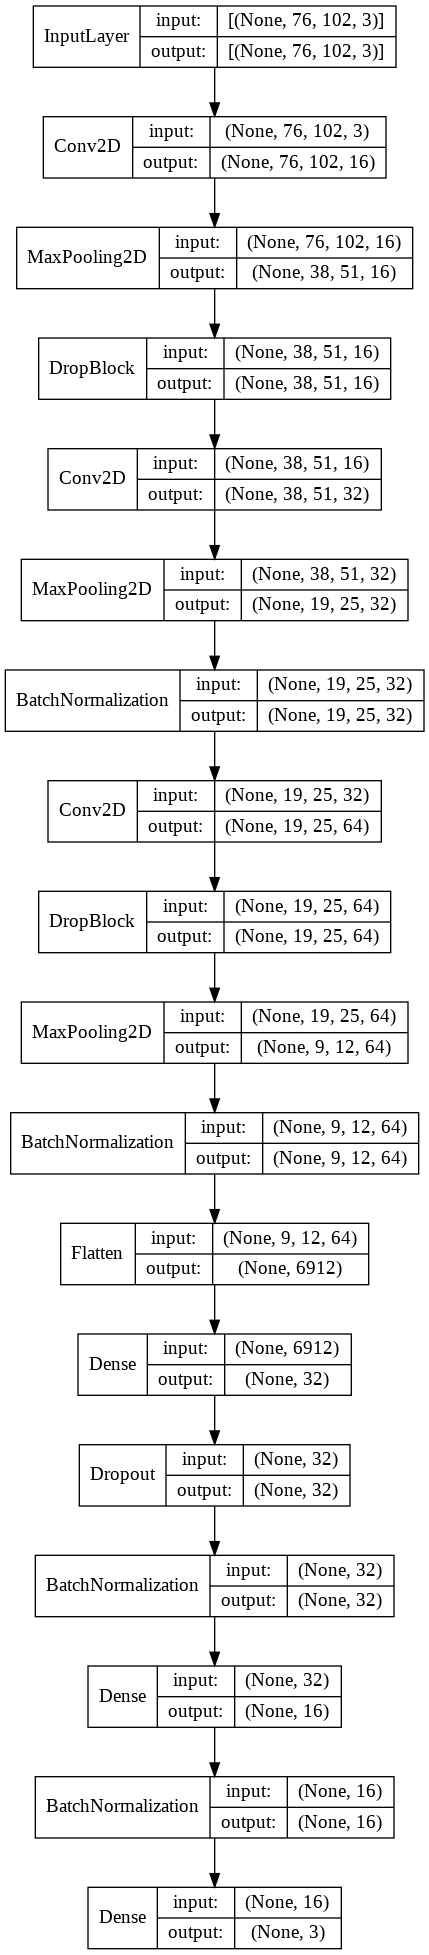

In [37]:
model3.build(input_shape=(32, 76, 102, 3))
model3.summary()
plot_model(model3, show_shapes=True, show_layer_names=False)

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('cnn_dropblock.h5', monitor='val_loss', mode='min', save_best_only=True)

In [39]:
history3 = model3.fit(X_train, Y_train, callbacks=[es, rlrop, mch], validation_data=(X_val, Y_val), epochs=90, batch_size=32)

Epoch 1/90
235/235 [==============================] - 10s 28ms/step - loss: 0.4110 - accuracy: 0.8384 - val_loss: 0.9648 - val_accuracy: 0.5493 - lr: 0.0010
Epoch 2/90
235/235 [==============================] - 4s 17ms/step - loss: 0.2050 - accuracy: 0.9255 - val_loss: 0.6374 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 3/90
235/235 [==============================] - 4s 16ms/step - loss: 0.1701 - accuracy: 0.9387 - val_loss: 0.1566 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 4/90
235/235 [==============================] - 3s 15ms/step - loss: 0.1241 - accuracy: 0.9584 - val_loss: 0.1136 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 5/90
235/235 [==============================] - 4s 17ms/step - loss: 0.1039 - accuracy: 0.9652 - val_loss: 0.1643 - val_accuracy: 0.9407 - lr: 0.0010
Epoch 6/90
235/235 [==============================] - 3s 15ms/step - loss: 0.0937 - accuracy: 0.9655 - val_loss: 0.1182 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 7/90
235/235 [==============================] - 4s 17ms/s

Text(0.5, 1.0, 'Accuracy')

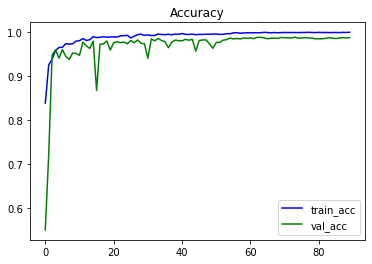

In [40]:
plt.plot(history3.history['accuracy'], color='blue',label = 'train_acc')
plt.plot(history3.history['val_accuracy'], color='green' , label = 'val_acc')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

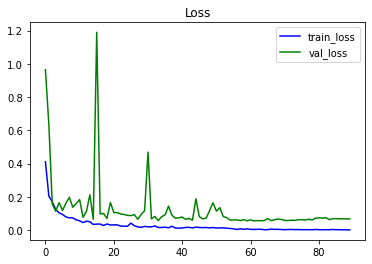

In [41]:
plt.plot(history3.history['loss'], color='blue',label = 'train_loss')
plt.plot(history3.history['val_loss'], color='green' , label='val_loss')
plt.legend()
plt.title('Loss')

In [42]:
score = model3.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

141/141 [==============================] - 1s 9ms/step - loss: 0.0724 - accuracy: 0.9856
Test loss: 0.07240868359804153
Test accuracy: 0.9855555295944214


In [43]:
Y_pred = model3.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

141/141 [==============================] - 1s 5ms/step


In [44]:
ccuracy = accuracy_score(Y_pred_labels , Y_test_labels)
recall = recall_score(Y_pred_labels , Y_test_labels , average = 'macro')
precision = precision_score(Y_pred_labels , Y_test_labels , average = 'macro')
print(f'accuracy:{accuracy :0.3f}\t Recall:{recall:0.3f} \t precision{precision:0.3f} \t loss:{score[0]:0.3f}' )

accuracy:0.972	 Recall:0.986 	 precision0.986 	 loss:0.072


In [45]:
del Y_pred , Y_pred_max , Y_pred_labels , model3, history3, rlrop, mch, es

## Part7:
با توجه به مفاهیم درس، در این بخش پارامتر های کرنل را به کمک فاکتوریزیشن کاهش میدهیم، برای این منظور از مقاله زیر کمک میگیریم و به این صورت عمل میکنیم که ابتدا ورودی را به یک فضای واسه میبریم، سپس کرنل های عمودی و افقی را بر روی تصویر اعمال میکنیم، پس از آن نتیجه را به فضای خروجی میبریم.
http://stanford.edu/class/ee367/Winter2019/bergman_report.pdf


میبینیم که تعداد پارامتر ها کاهش میابید و با کمتر کردن بعد فضای واسط باز هم میتوان کاهش پارامتر داشت اما نتیجه مطلوب نبود، در مورد نتیجه هم بعضا نتایج بهتری حاصل گردید. 

In [46]:
model4 = Sequential()
model4.add(Conv2D(3, (1, 1), activation='relu', input_shape=(76, 102, 3) , name = 'Conv2D-1-1' , padding = 'same'))
model4.add(Conv2D(3, (1, 3), activation='relu',  name = 'Conv2D-1-2' , padding = 'same'))
model4.add(Conv2D(3, (3, 1), activation='relu',  name = 'Conv2D-1-3' , padding = 'same'))
model4.add(Conv2D(16, (1, 1), activation='relu',  name = 'Conv2D-1-4' , padding = 'same'))


model4.add(MaxPool2D(pool_size=(2, 2) , name = 'MaxPool-1', padding = 'same'))
model4.add(DropBlock(keep_prob=0.9, block_size=3))

#model3.add(Dropout(.1, name='Dropout1'))
#model4.add(Conv2D(32, (3, 3), activation='relu', name = 'Conv2D-2', padding = 'same'))
model4.add(Conv2D(16, (1, 1), activation='relu',  name = 'Conv2D-2-1' , padding = 'same'))
model4.add(Conv2D(16, (1, 3), activation='relu',  name = 'Conv2D-2-2' , padding = 'same'))
model4.add(Conv2D(16, (3, 1), activation='relu',  name = 'Conv2D-2-3' , padding = 'same'))
model4.add(Conv2D(32, (1, 1), activation='relu',  name = 'Conv2D-2-4' , padding = 'same'))

model4.add(MaxPool2D(pool_size=(2, 2), name = 'MaxPool-2'))
model4.add(BatchNormalization())
#model4.add(Conv2D(64, (3, 3), activation='relu', name = 'Conv2D-3', padding = 'same'))
model4.add(Conv2D(32, (1, 1), activation='relu',  name = 'Conv2D-3-1' , padding = 'same'))
model4.add(Conv2D(32, (1, 3), activation='relu',  name = 'Conv2D-3-2' , padding = 'same'))
model4.add(Conv2D(32, (3, 1), activation='relu',  name = 'Conv2D-3-3' , padding = 'same'))
model4.add(Conv2D(64, (1, 1), activation='relu',  name = 'Conv2D-3-4' , padding = 'same'))

model4.add(DropBlock(keep_prob=0.9, block_size=3))
model4.add(MaxPool2D(pool_size=(2, 2), name = 'MaxPool-3'))
model4.add(BatchNormalization())
model4.add(Flatten( name = 'Flatten'))
model4.add(Dense(32, activation='relu', name = 'Dense-1'))
model4.add(Dropout(.1, name='Dropout3'))
model4.add(BatchNormalization())
model4.add(Dense(16, activation='relu', name = 'Dense-2'))
model4.add(BatchNormalization())
model4.add(Dense(3, activation='softmax', name = 'Dense-3'))

In [47]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1-1 (Conv2D)         (None, 76, 102, 3)        12        
                                                                 
 Conv2D-1-2 (Conv2D)         (None, 76, 102, 3)        30        
                                                                 
 Conv2D-1-3 (Conv2D)         (None, 76, 102, 3)        30        
                                                                 
 Conv2D-1-4 (Conv2D)         (None, 76, 102, 16)       64        
                                                                 
 MaxPool-1 (MaxPooling2D)    (None, 38, 51, 16)        0         
                                                                 
 drop_block_2 (DropBlock)    (None, 38, 51, 16)        0         
                                                                 
 Conv2D-2-1 (Conv2D)         (None, 38, 51, 16)       

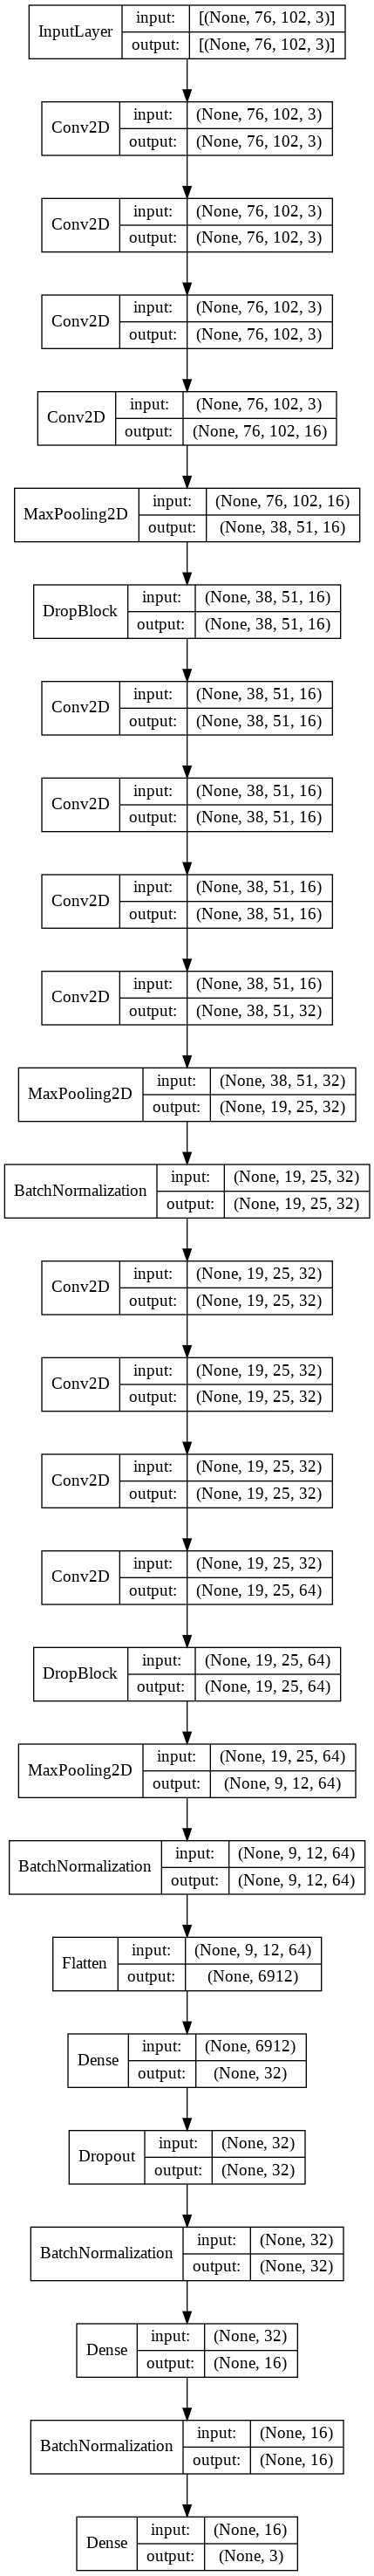

In [48]:
model4.build(input_shape=(32, 76, 102, 3))
model4.summary()
plot_model(model4, show_shapes=True, show_layer_names=False)

In [49]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('cnn_kernelfactorization.h5', monitor='val_loss', mode='min', save_best_only=True)

In [50]:
history4 = model4.fit(X_train, Y_train, callbacks=[es, rlrop, mch], validation_data=(X_val, Y_val), epochs=90, batch_size=32)

Epoch 1/90
235/235 [==============================] - 13s 39ms/step - loss: 0.4229 - accuracy: 0.8416 - val_loss: 1.1741 - val_accuracy: 0.3213 - lr: 0.0010
Epoch 2/90
235/235 [==============================] - 6s 25ms/step - loss: 0.2132 - accuracy: 0.9257 - val_loss: 0.7269 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 3/90
235/235 [==============================] - 7s 29ms/step - loss: 0.1858 - accuracy: 0.9347 - val_loss: 0.3799 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 4/90
235/235 [==============================] - 7s 29ms/step - loss: 0.1548 - accuracy: 0.9484 - val_loss: 0.1840 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 5/90
235/235 [==============================] - 6s 25ms/step - loss: 0.1261 - accuracy: 0.9568 - val_loss: 1.8911 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 6/90
235/235 [==============================] - 5s 23ms/step - loss: 0.0987 - accuracy: 0.9659 - val_loss: 0.1777 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 7/90
235/235 [==============================] - 6s 25ms/s

Text(0.5, 1.0, 'Accuracy')

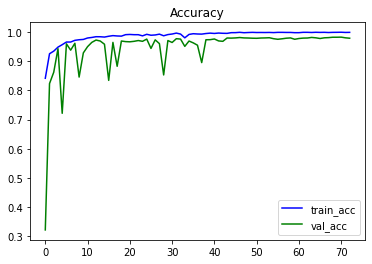

In [51]:
plt.plot(history4.history['accuracy'], color='blue',label = 'train_acc')
plt.plot(history4.history['val_accuracy'], color='green' , label = 'val_acc')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

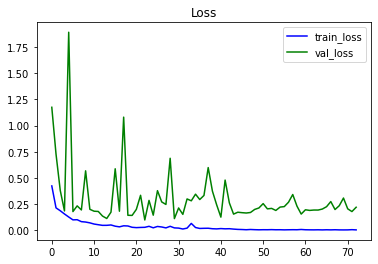

In [52]:
plt.plot(history4.history['loss'], color='blue',label = 'train_loss')
plt.plot(history4.history['val_loss'], color='green' , label='val_loss')
plt.legend()
plt.title('Loss')

In [53]:
score = model4.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

141/141 [==============================] - 1s 7ms/step - loss: 0.1183 - accuracy: 0.9787
Test loss: 0.11829805374145508
Test accuracy: 0.9786666631698608


In [54]:
Y_pred = model4.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

141/141 [==============================] - 1s 5ms/step


In [55]:
ccuracy = accuracy_score(Y_pred_labels , Y_test_labels)
recall = recall_score(Y_pred_labels , Y_test_labels , average = 'macro')
precision = precision_score(Y_pred_labels , Y_test_labels , average = 'macro')
print(f'accuracy:{accuracy :0.3f}\t Recall:{recall:0.3f} \t precision{precision:0.3f} \t loss:{score[0]:0.3f}' )

accuracy:0.972	 Recall:0.979 	 precision0.979 	 loss:0.118


In [56]:
del Y_pred , Y_pred_max , Y_pred_labels , model4, history4, rlrop, mch, es

در مجموع و به طور کلی و بر اثر ران های متعدد جمع بندی ما از دقت 4 مدل ترین شده به صورت زیر شد
dropblock>factorization>dropout>MLP